## XGBoost
- Mainly used for classification and regression modeling
- **Ensemble Learning:** Combines multiple weak prediction models (typically decision trees) to create a robust predictive model

<img src="decisionTree.png" width="500"/>   <img src="Bagging-Ensemble.png" width="400" height="100"/>

In [465]:
#import packages
import pyodbc as db
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

#connect to DB
server = 'tcp:usaepwvds025.database.windows.net' 
database = 'SIMS' 
username = 'ciaserviceaccount' 
password = 'pipeline$330' 
cnxn = db.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)

#load dataframe
sql = "select * from sims.logisticRegression"
df = pd.read_sql(sql,cnxn)

df = df.drop(columns=['LegacyAccountID', 'CurrentCompanyID', 'OpportunityID'])

df = df.drop(columns = 'CloseComments')

df = df.drop(columns = 'StartDate')

df.query('LegacyAccountName != LegacyAccountName')

df.dropna(subset=['LegacyAccountName'], inplace=True)

modeMarketCap = df['CurrentCompanyMarketCapCategory'].mode()
print(modeMarketCap)
df['CurrentCompanyMarketCapCategory'].fillna(df['CurrentCompanyMarketCapCategory'].mode()[0], inplace=True)

meanMarketCap = df.groupby('CurrentCompanyMarketCapCategory')['CurrentCompanyMarketCap'].mean().reset_index()
print(meanMarketCap)
totalMeanMarketCap = df['CurrentCompanyMarketCap'].mean()
print(totalMeanMarketCap)

df['CurrentCompanyMarketCap'] = df['CurrentCompanyMarketCap'].fillna(df.groupby('CurrentCompanyMarketCapCategory')['CurrentCompanyMarketCap'].transform('mean'))

df['CurrentCompanyMarketCap'].fillna(totalMeanMarketCap, inplace = True)

df['Top12CMMCompany'].fillna('False', inplace = True)
df['Top24CMMCompany'].fillna('False', inplace = True)

avgTotalOppAmt = df['TotalOpportunityAmount'].mean()
print(avgTotalOppAmt)
df['TotalOpportunityAmount'].fillna(avgTotalOppAmt, inplace = True)

CloseReasonMode = df['CloseReason'].mode()
print(CloseReasonMode)

df.loc[(df['CloseReason'].isna()) & (df['StageName'] == "Closed Lost"), 'CloseReason'] = "CloseReasonMode"

df.loc[(df['CloseReason'].isna()) & (df['StageName'] == "Closed Won"), 'CloseReason'] = "Won"

df['CreateDateMonth'] = df['CreateDate'].dt.month 

0    Large
Name: CurrentCompanyMarketCapCategory, dtype: object
  CurrentCompanyMarketCapCategory  CurrentCompanyMarketCap
0                           Large             8.918423e+10
1                          Medium             5.183144e+09
2                            Mega             3.620157e+11
3                           Micro             8.615721e+07
4                   Not Available                      NaN
5                         Private                      NaN
6                           Small             1.121949e+09
133256202249.96771
753393.6349527403
0    No Bid
Name: CloseReason, dtype: object


In [466]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27574 entries, 0 to 27593
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   LegacySFInstance                 27574 non-null  object        
 1   LegacyAccountName                27574 non-null  object        
 2   CurrentCompanyGroup              27574 non-null  object        
 3   CurrentCompanyMarketCap          27574 non-null  float64       
 4   CurrentCompanyMarketCapCategory  27574 non-null  object        
 5   Top12CMMCompany                  27574 non-null  object        
 6   Top24CMMCompany                  27574 non-null  object        
 7   OpportunityName                  27574 non-null  object        
 8   OpportunityType                  27574 non-null  object        
 9   TotalOpportunityAmount           27574 non-null  float64       
 10  CreateDate                       27574 non-null  datetime64[ns]

In [467]:
df['StageName'] = df['StageName'].map({'Closed Won': 1, 'Closed Lost': 0})

winRate = (sum(df['StageName'])/len(df['StageName'].index))*100
print(winRate)

55.93312540799303


In [468]:
winDF = df.query('StageName == True')

In [469]:
winDF.shape

(15423, 16)

In [470]:
lossDF = df.query('StageName == False')

In [471]:
nrows = lossDF.shape[0]
print(nrows)

12151


In [472]:
winDF = winDF.sample(n=nrows, random_state = 1)

In [473]:
newDF = pd.concat([winDF, lossDF], ignore_index = False)

In [474]:
newDF

,LegacySFInstance,LegacyAccountName,CurrentCompanyGroup,CurrentCompanyMarketCap,CurrentCompanyMarketCapCategory,Top12CMMCompany,Top24CMMCompany,OpportunityName,OpportunityType,TotalOpportunityAmount,CreateDate,OpportunityOwner,StageName,CloseReason,ImpactedFY,CreateDateMonth
3207,RHP,Boehringer Ingelheim,Boehringer Ingelheim,1.332562e+11,Private,YES,False,BI_eV_2021 1st Amnd for Jentadueto,Renewal,0.000000,2021-03-31 21:19:59,Laura Redman,1,Won,FY 2022,3
19338,CMM,Amneal Pharmaceuticals,Amneal Pharmaceuticals,1.796349e+09,Small,False,False,Amneal Ongentys HubExpress,New,322660.000000,2023-12-12 20:20:05,Josh Lobs,1,Won,FY 2024,12
16694,RHP,AssertioRx (fka Depomed),Assertio Holdings,8.181254e+07,Micro,False,False,Depomed_Gralise_eVNTT,New,564000.000000,2013-03-19 18:15:51,Lauren Howard,1,Won,FY 2014,3
20594,RxC,Clovis Oncology,Clovis Oncology,1.332562e+11,Private,False,False,Clovis: 2020 Exhibits,New,150000.000000,2019-09-27 18:58:13,John Archie,1,Won,FY 2020,9
22994,CMM,AbbVie,AbbVie,3.055616e+11,Mega,YES,False,AbbVie Skyrizi PA Ready Portal,New,21.000000,2020-01-28 21:07:07,Renee Kasun,1,Won,FY 2020,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27580,RHP,Fresenius Medical Care North America,Fresenius Medical Care North America,1.332562e+11,Not Available,False,False,Fresenius_PriorAuthPlus,New,753393.634953,2014-12-16 16:12:08,Marissa Presnell,0,No Bid,FY 2016,12
27583,CMM,Otter Pharmaceuticals,Otter Pharmaceuticals,1.332562e+11,Not Available,False,False,Otter Sympazan HubExpress Renewal 2023-10,Renewal,94484.000000,2023-01-30 15:50:04,David Schneider,0,Price,FY 2024,1
27585,CMM,Otter Pharmaceuticals,Otter Pharmaceuticals,1.332562e+11,Not Available,False,False,Otter Sympazan Prior Authorization Plus Renewa...,Renewal,93713.000000,2023-07-25 19:55:48,Catherine Buchanan,0,Price,FY 2024,7
27586,RxC,Omeza,Omeza,1.332562e+11,Not Available,False,False,Omeza Collagen Matrix Hub RFP,New,732794.000000,2023-03-21 17:50:15,Aimee Crawley,0,Pricing,FY 2024,3


In [475]:
winRate = (sum(newDF['StageName'])/len(newDF['StageName'].index))*100
print(winRate)

50.0


In [476]:
pd.crosstab(newDF['ImpactedFY'],newDF['StageName'])

StageName,0,1
ImpactedFY,,
FY 1999,549,0
FY 2005,2,0
FY 2007,0,13
FY 2008,49,219
FY 2009,122,115
FY 2010,212,174
FY 2011,315,192
FY 2012,273,387
FY 2013,468,382


<Axes: title={'center': 'Stage Name vs Impacted Fiscal Year'}, xlabel='ImpactedFY'>

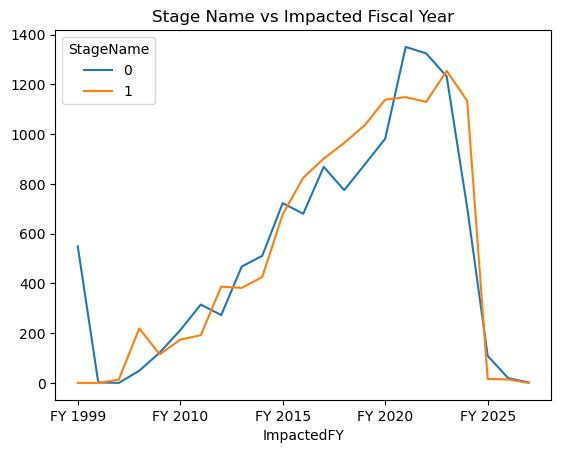

In [477]:
pd.crosstab(newDF['ImpactedFY'],newDF['StageName']).plot(kind='line', title = 'Stage Name vs Impacted Fiscal Year')

<Axes: title={'center': 'Stage Name vs Create Date Month'}, xlabel='CreateDateMonth'>

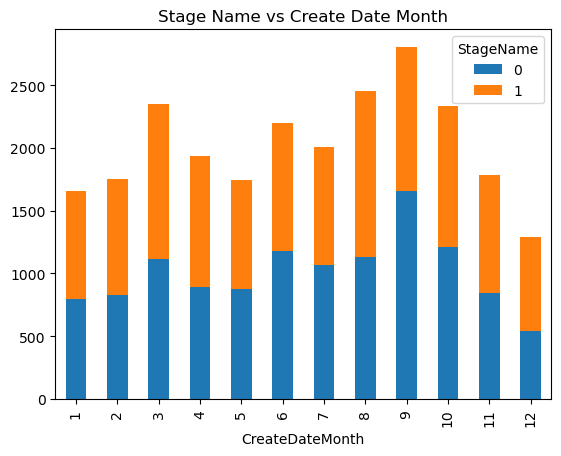

In [478]:
pd.crosstab(newDF['CreateDateMonth'],newDF['StageName']).plot(kind='bar', stacked = True, title = 'Stage Name vs Create Date Month')

<Axes: title={'center': 'Total Wins by Create Date'}, xlabel='CreateDate'>

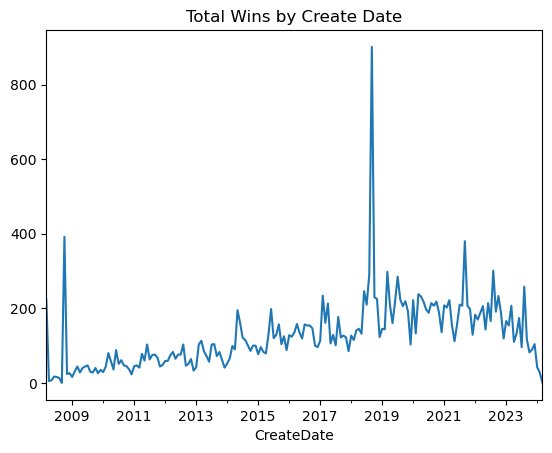

In [479]:
newDF.set_index('CreateDate', inplace = True)
newDF.resample('1M').count()['StageName'].plot(title = 'Total Wins by Create Date')

<Axes: title={'center': 'Stage Name by Legacy SF Instance'}, xlabel='LegacySFInstance'>

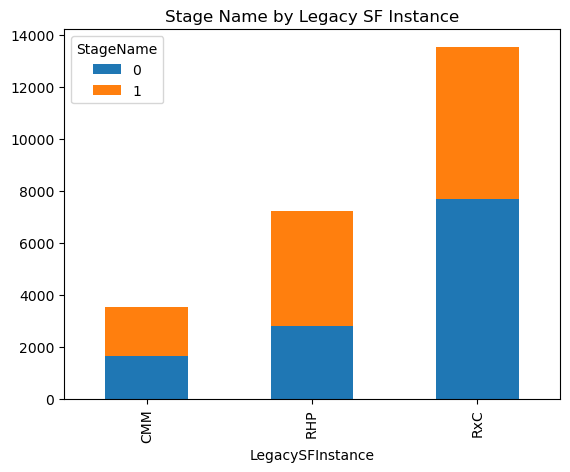

In [480]:
pd.crosstab(newDF['LegacySFInstance'],newDF['StageName']).plot(kind="bar", stacked=True, title = "Stage Name by Legacy SF Instance")

<Axes: title={'center': 'Stage Name by Market Cap Category'}, xlabel='CurrentCompanyMarketCapCategory'>

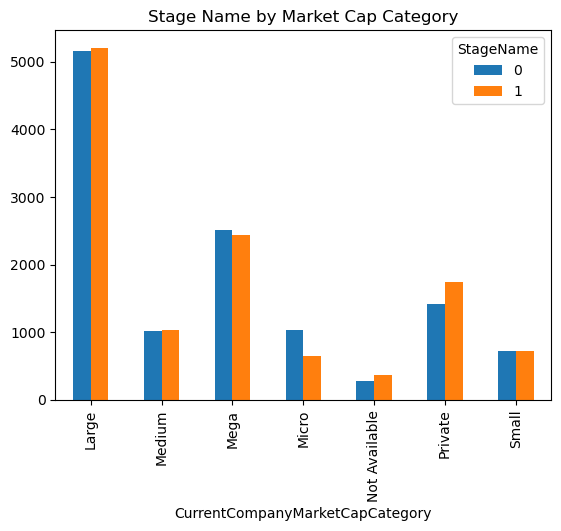

In [481]:
pd.crosstab(newDF['CurrentCompanyMarketCapCategory'],newDF['StageName']).plot(kind="bar", stacked=False, title="Stage Name by Market Cap Category")

In [482]:
newDF.reset_index('CreateDate', inplace= True)

In [483]:
newDF.describe()

,CreateDate,CurrentCompanyMarketCap,TotalOpportunityAmount,StageName,CreateDateMonth
count,24302,2.430200e+04,2.430200e+04,24302.00000,24302.000000
mean,2018-01-01 21:34:30.144885248,1.324563e+11,7.646521e+05,0.50000,6.550654
min,2008-03-17 18:16:52,6.493000e+01,-2.800000e+06,0.00000,1.000000
25%,2015-06-15 18:36:56.750000128,1.434807e+10,5.000000e+03,0.00000,4.000000
50%,2018-09-17 22:26:58,1.131137e+11,8.000000e+04,0.50000,7.000000
75%,2021-02-23 16:48:49.500000,1.576153e+11,3.191300e+05,1.00000,9.000000
max,2024-03-04 14:30:36,6.998863e+11,1.188350e+09,1.00000,12.000000
std,NaN,1.492715e+11,1.343540e+07,0.50001,3.257991


In [484]:
newDF.describe(include='object')

,LegacySFInstance,LegacyAccountName,CurrentCompanyGroup,CurrentCompanyMarketCapCategory,Top12CMMCompany,Top24CMMCompany,OpportunityName,OpportunityType,OpportunityOwner,CloseReason,ImpactedFY
count,24302,24302,24302,24302,24302,24302,24302,24302,24302,24302,24302
unique,3,1619,911,7,2,2,22996,3,243,76,23
top,RxC,"Merck & Co., Inc.",Bristol Myers Squibb,Large,False,False,eVoucher,New,Admin User,Won,FY 2021
freq,13521,756,1314,10373,15493,20401,32,17621,2242,10589,2500


In [485]:
newDF = newDF.drop(columns=['LegacyAccountName', 'CurrentCompanyGroup', 'OpportunityName', 'OpportunityOwner', 'CloseReason', 'CreateDate', 'ImpactedFY'])

In [486]:
newDF = pd.get_dummies(newDF, columns=["LegacySFInstance", "CurrentCompanyMarketCapCategory", "Top12CMMCompany", "Top24CMMCompany", "OpportunityType", "CreateDateMonth"], prefix=["LegacySFInstance", "CurrentCompanyMarketCapCategory", "Top12CMMCompany", "Top24CMMCompany", "OpportunityType", "CreateDateMonth"], drop_first = True)     

In [487]:
newDF.head()

,CurrentCompanyMarketCap,TotalOpportunityAmount,StageName,LegacySFInstance_RHP,LegacySFInstance_RxC,CurrentCompanyMarketCapCategory_Medium,CurrentCompanyMarketCapCategory_Mega,CurrentCompanyMarketCapCategory_Micro,CurrentCompanyMarketCapCategory_Not Available,CurrentCompanyMarketCapCategory_Private,...,CreateDateMonth_3,CreateDateMonth_4,CreateDateMonth_5,CreateDateMonth_6,CreateDateMonth_7,CreateDateMonth_8,CreateDateMonth_9,CreateDateMonth_10,CreateDateMonth_11,CreateDateMonth_12
0,1.332562e+11,0.0,1,True,False,False,False,False,False,True,...,True,False,False,False,False,False,False,False,False,False
1,1.796349e+09,322660.0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,8.181254e+07,564000.0,1,True,False,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,False
3,1.332562e+11,150000.0,1,False,True,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
4,3.055616e+11,21.0,1,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [488]:
newDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24302 entries, 0 to 24301
Data columns (total 26 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   CurrentCompanyMarketCap                        24302 non-null  float64
 1   TotalOpportunityAmount                         24302 non-null  float64
 2   StageName                                      24302 non-null  int64  
 3   LegacySFInstance_RHP                           24302 non-null  bool   
 4   LegacySFInstance_RxC                           24302 non-null  bool   
 5   CurrentCompanyMarketCapCategory_Medium         24302 non-null  bool   
 6   CurrentCompanyMarketCapCategory_Mega           24302 non-null  bool   
 7   CurrentCompanyMarketCapCategory_Micro          24302 non-null  bool   
 8   CurrentCompanyMarketCapCategory_Not Available  24302 non-null  bool   
 9   CurrentCompanyMarketCapCategory_Private        243

In [489]:
newDF = newDF.replace({True: 1, False: 0})

In [490]:
import seaborn as sb
import statsmodels.api as sm

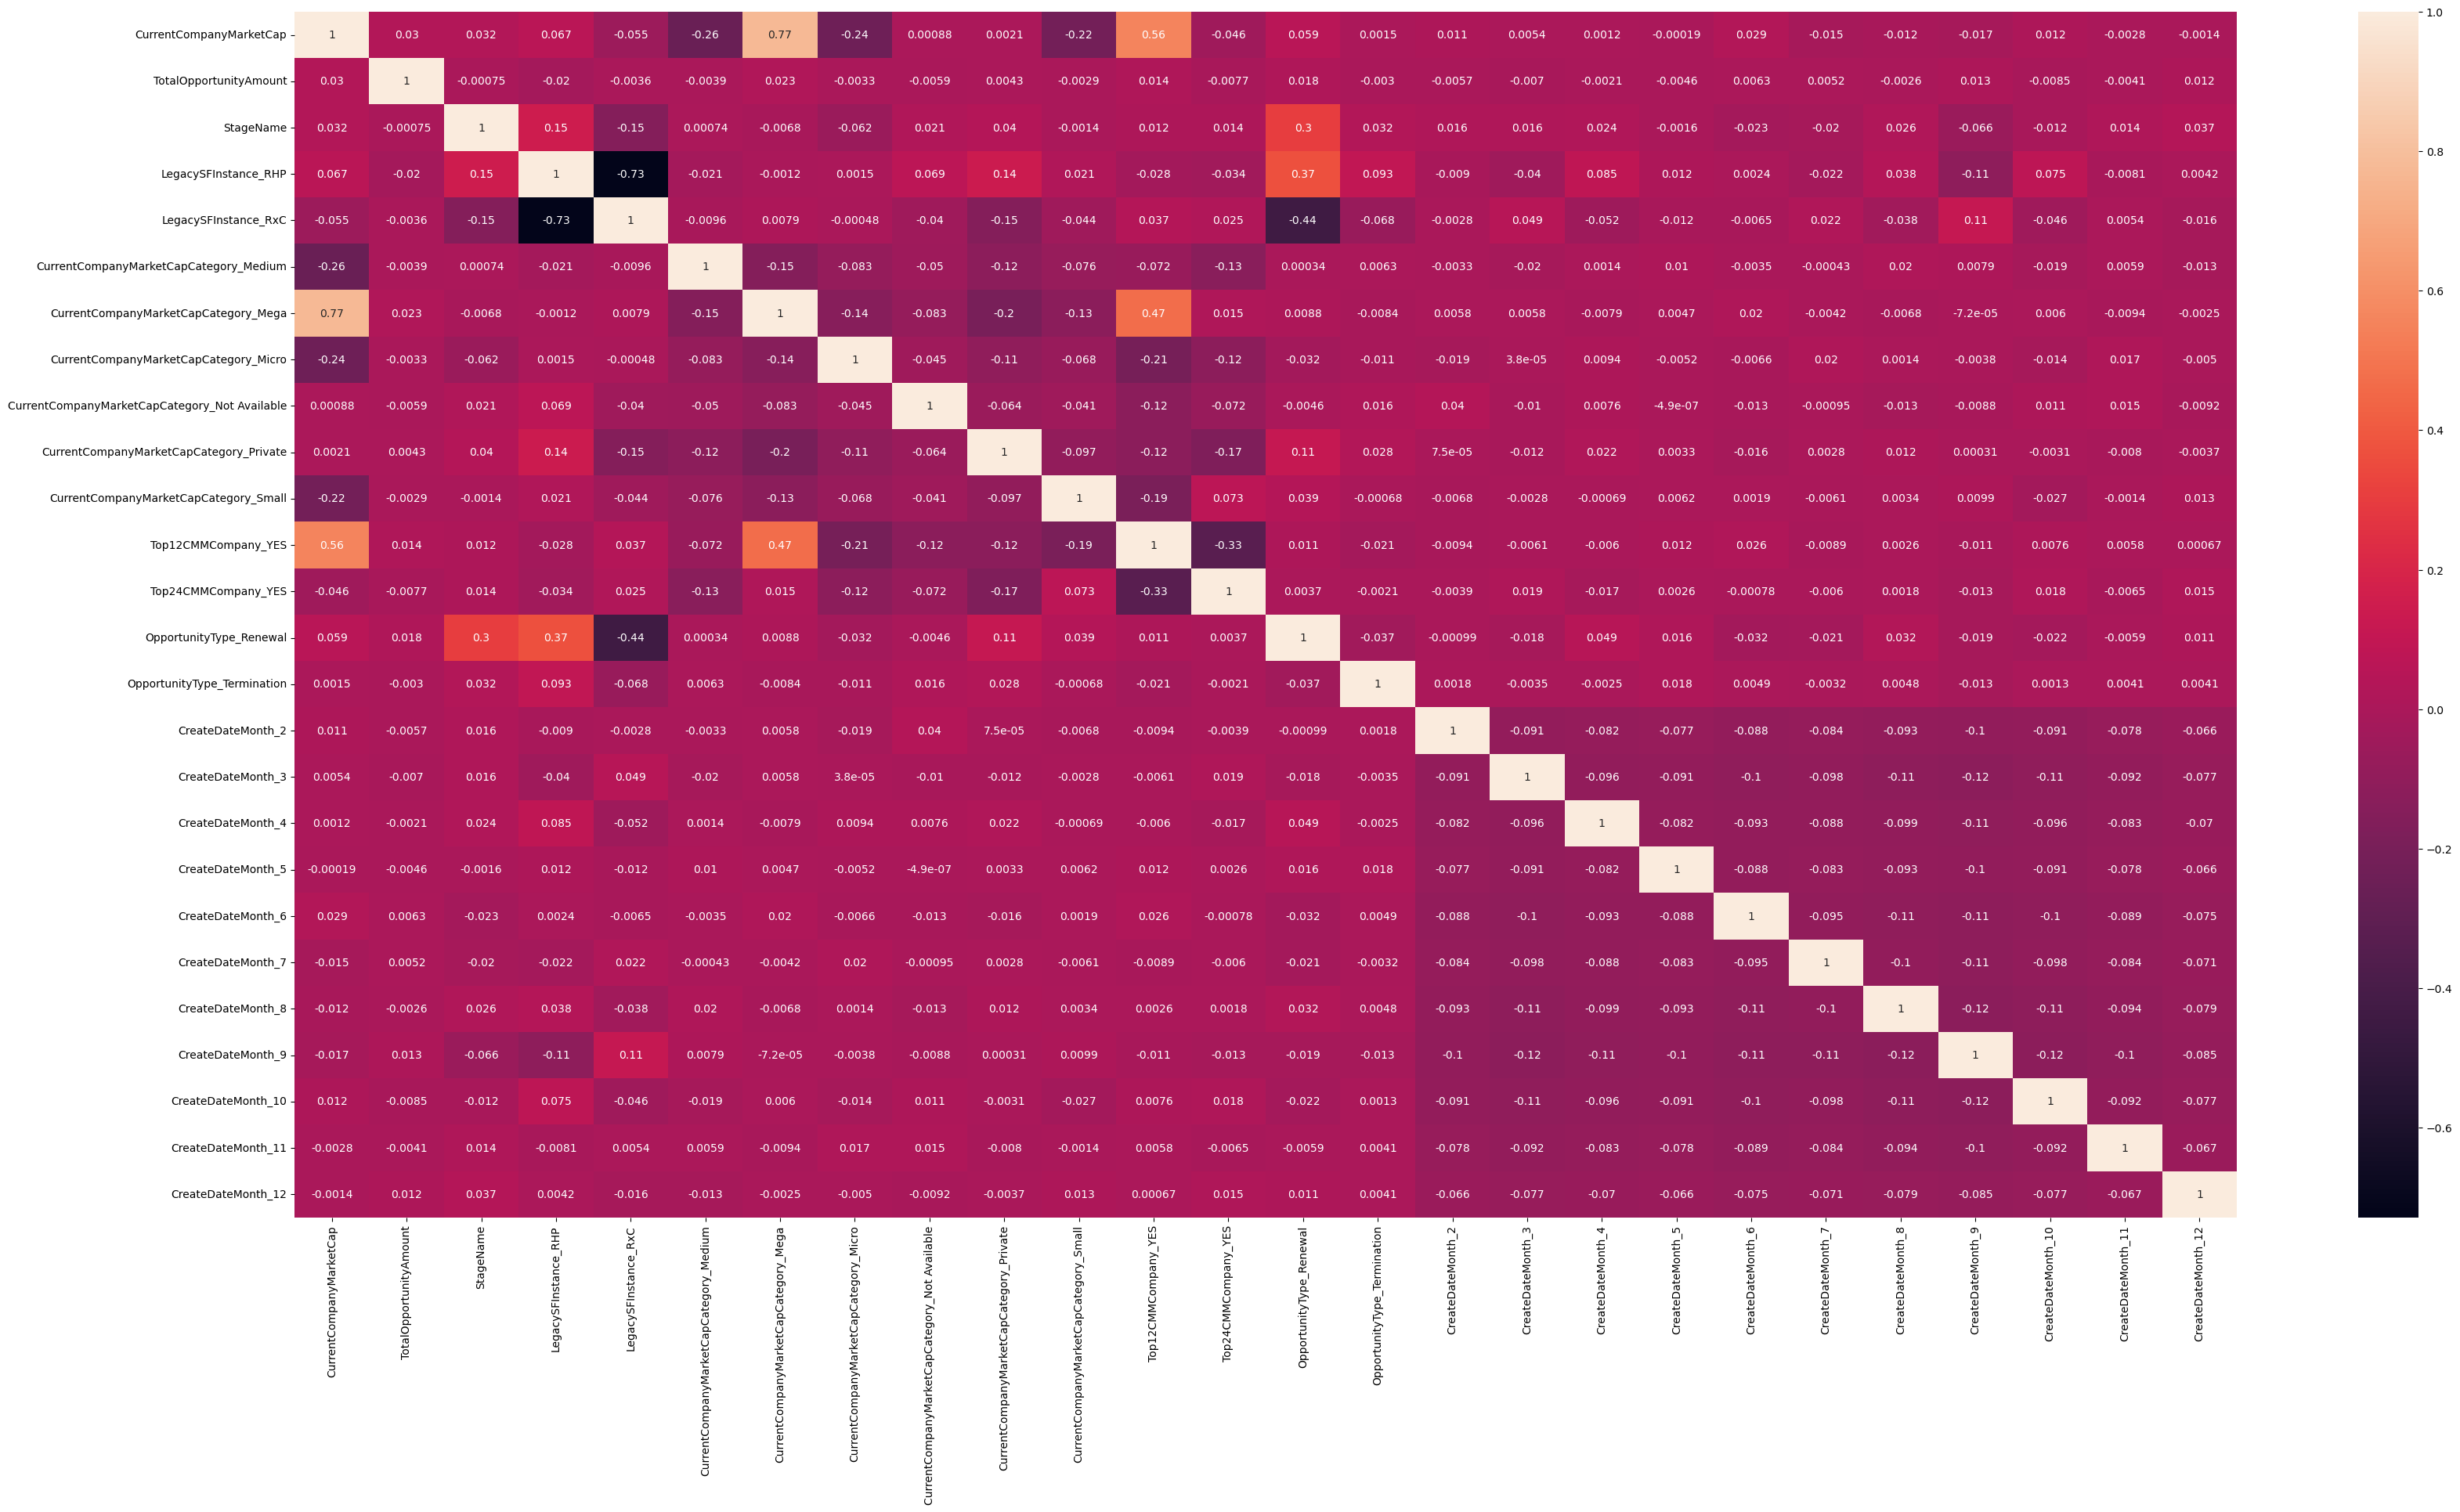

In [491]:
import matplotlib.pyplot as plt
plt.figure(figsize = (40,20))
sb.heatmap(newDF.corr(), annot = True)
plt.show()

In [492]:
X = newDF.drop(['StageName', 'Top12CMMCompany_YES'], axis=1)
y = newDF['StageName']

In [493]:
from sklearn.model_selection import train_test_split #split train and test set
from sklearn.preprocessing import MinMaxScaler #scale features
import numpy as np

In [494]:
######split data
#split the training and testing sets
 
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

In [496]:
y_train_predict2['Prediction'] = y_train_predict2.StageNameProbability.map(lambda x: 1 if x > 0.5 else 0)
y_train_predict2

,StageName,StageNameProbability,Prediction
17220,0,0.329118,0
7311,1,0.658918,1
22066,0,0.406757,0
11247,1,0.344185,0
8569,1,0.763263,1
...,...,...,...
13123,0,0.406757,0
19648,0,0.406757,0
9845,1,0.502360,1
10799,1,0.406757,0


In [560]:
import sys
!{sys.executable} -m pip install xgboost
from xgboost import XGBClassifier
# Create an instance of the XGBClassifier
model = XGBClassifier(objective='binary:logistic')

# Fit the model to the training data
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [558]:
model.get_booster().get_score(importance_type="gain")

{'CurrentCompanyMarketCap': 1.9916019439697266,
 'TotalOpportunityAmount': 5.05204963684082,
 'LegacySFInstance_RHP': 3.9695162773132324,
 'LegacySFInstance_RxC': 8.438461303710938,
 'CurrentCompanyMarketCapCategory_Medium': 1.9795217514038086,
 'CurrentCompanyMarketCapCategory_Micro': 0.8099033236503601,
 'CurrentCompanyMarketCapCategory_Not Available': 1.6619688272476196,
 'CurrentCompanyMarketCapCategory_Private': 2.004059314727783,
 'CurrentCompanyMarketCapCategory_Small': 1.2659512758255005,
 'Top24CMMCompany_YES': 1.964383602142334,
 'OpportunityType_Renewal': 26.86764907836914,
 'OpportunityType_Termination': 3.0351717472076416,
 'CreateDateMonth_2': 2.3154213428497314,
 'CreateDateMonth_3': 2.1006739139556885,
 'CreateDateMonth_4': 1.896562099456787,
 'CreateDateMonth_5': 1.941256046295166,
 'CreateDateMonth_6': 2.0299320220947266,
 'CreateDateMonth_7': 1.8846689462661743,
 'CreateDateMonth_8': 2.0796425342559814,
 'CreateDateMonth_9': 2.4742345809936523,
 'CreateDateMonth_10':

In [497]:
y_pred = model.predict(X_train)
print(y_pred)

[0 1 0 ... 0 1 0]


In [499]:
y_pred_proba = model.predict_proba(X_train)
y_pred_proba

array([[0.9468191 , 0.05318085],
       [0.11833805, 0.88166195],
       [0.97260165, 0.02739837],
       ...,
       [0.5341213 , 0.4658787 ],
       [0.12367707, 0.8763229 ],
       [0.6138352 , 0.38616478]], dtype=float32)

In [498]:
yPred = pd.DataFrame({'StageName':y_train.values, 'StageNameValue': y_pred})
yPred.head()

,StageName,StageNameValue
0,0,0
1,1,1
2,0,0
3,1,1
4,1,1


In [500]:
accuracy = model.score(X_train, y_train)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.37%


In [501]:
y_pred3 = model.predict(X_test)
print(y_pred3)

[1 1 1 ... 0 0 0]


In [502]:
yPred3 = pd.DataFrame({'StageName':y_test.values, 'StageNameValue': y_pred3})
yPred3.head()

,StageName,StageNameValue
0,1,1
1,0,1
2,1,1
3,0,0
4,1,1


In [503]:
X_test

,CurrentCompanyMarketCap,TotalOpportunityAmount,LegacySFInstance_RHP,LegacySFInstance_RxC,CurrentCompanyMarketCapCategory_Medium,CurrentCompanyMarketCapCategory_Mega,CurrentCompanyMarketCapCategory_Micro,CurrentCompanyMarketCapCategory_Not Available,CurrentCompanyMarketCapCategory_Private,CurrentCompanyMarketCapCategory_Small,...,CreateDateMonth_3,CreateDateMonth_4,CreateDateMonth_5,CreateDateMonth_6,CreateDateMonth_7,CreateDateMonth_8,CreateDateMonth_9,CreateDateMonth_10,CreateDateMonth_11,CreateDateMonth_12
1620,3.060335e+09,2.028000e+06,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
23914,1.269218e+10,5.850000e+03,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
6721,6.998863e+11,1.069000e+05,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20628,4.546068e+06,7.533936e+05,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7260,6.266720e+10,3.000000e+04,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17133,1.174317e+11,1.585000e+05,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
15532,2.054867e+11,1.005000e+05,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
23127,3.799889e+11,1.000000e+05,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
14161,1.359557e+10,1.000000e+00,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [504]:
y_pred_proba2 = model.predict_proba(X_test)
y_pred_proba2

array([[0.14640945, 0.85359055],
       [0.21068859, 0.7893114 ],
       [0.1764065 , 0.8235935 ],
       ...,
       [0.7689806 , 0.2310194 ],
       [0.9487352 , 0.0512648 ],
       [0.657544  , 0.34245595]], dtype=float32)

In [505]:
# Calculate accuracy
accuracy = model.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 72.43%


In [506]:
from sklearn.metrics import log_loss, roc_auc_score

# Calculate log loss
log_loss(y_train, y_pred_proba)

# Calculate ROC AUC
roc_auc_score(y_train, y_pred_proba[:,1])

0.8963171936773918

In [507]:
from sklearn.metrics import log_loss, roc_auc_score

# Calculate log loss
log_loss(y_test, y_pred_proba2)

# Calculate ROC AUC
roc_auc_score(y_test, y_pred_proba2[:,1])

0.8029873422293659

In [508]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      8530
           1       0.81      0.82      0.81      8481

    accuracy                           0.81     17011
   macro avg       0.81      0.81      0.81     17011
weighted avg       0.81      0.81      0.81     17011



In [509]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72      3621
           1       0.72      0.74      0.73      3670

    accuracy                           0.72      7291
   macro avg       0.72      0.72      0.72      7291
weighted avg       0.72      0.72      0.72      7291



In [510]:
yPred

,StageName,StageNameValue
0,0,0
1,1,1
2,0,0
3,1,1
4,1,1
...,...,...
17006,0,0
17007,0,0
17008,1,0
17009,1,1


In [511]:
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba[:,1])
roc_auc = roc_auc_score(y_train, y_pred)
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_proba2[:,1])
roc_auc2 = roc_auc_score(y_test, y_pred3)

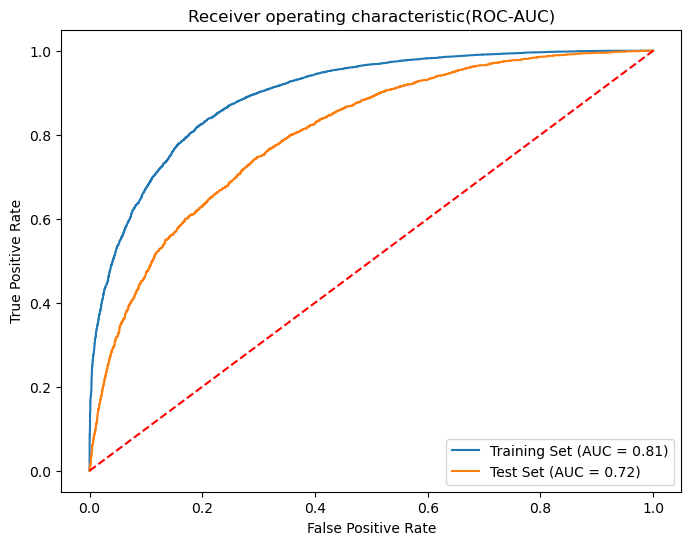

In [512]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='Training Set (AUC = %0.2f)' % roc_auc)
plt.plot(fpr2, tpr2,label='Test Set (AUC = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic(ROC-AUC)')
plt.legend(loc="lower right")
plt.show()

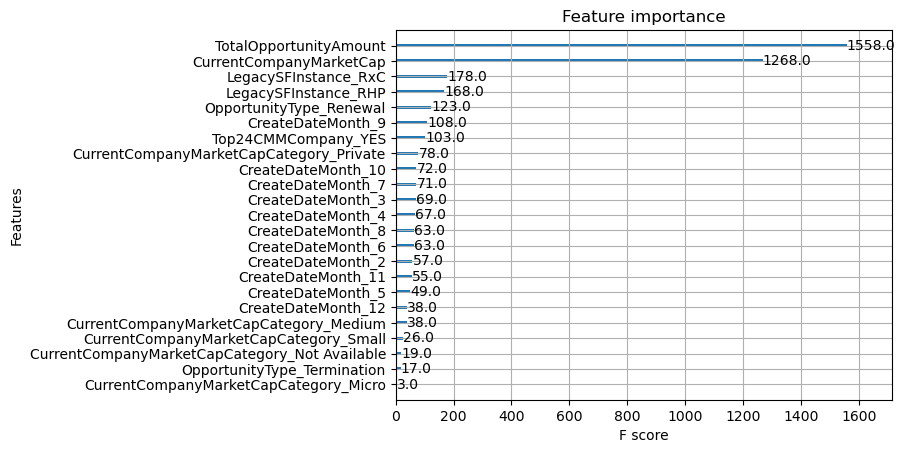

In [513]:
# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

plot_importance(model)
pyplot.show()

In [514]:
# use feature importance for feature selection
from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)
	# train model
	selection_model = XGBClassifier()
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_test = selection.transform(X_test)
	y_pred = selection_model.predict(select_X_test)
	predictions = [round(value) for value in y_pred]
	accuracy = accuracy_score(y_test, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Accuracy: 72.43%
Thresh=0.000, n=24, Accuracy: 72.43%
Thresh=0.010, n=23, Accuracy: 72.43%
Thresh=0.015, n=22, Accuracy: 72.34%
Thresh=0.020, n=21, Accuracy: 72.47%
Thresh=0.021, n=20, Accuracy: 72.08%
Thresh=0.023, n=19, Accuracy: 71.84%
Thresh=0.023, n=18, Accuracy: 72.32%
Thresh=0.023, n=17, Accuracy: 72.34%
Thresh=0.024, n=16, Accuracy: 72.47%
Thresh=0.024, n=15, Accuracy: 72.42%
Thresh=0.024, n=14, Accuracy: 72.57%
Thresh=0.024, n=13, Accuracy: 71.88%
Thresh=0.025, n=12, Accuracy: 71.49%
Thresh=0.025, n=11, Accuracy: 71.91%
Thresh=0.025, n=10, Accuracy: 71.91%
Thresh=0.027, n=9, Accuracy: 71.62%
Thresh=0.028, n=8, Accuracy: 71.28%
Thresh=0.030, n=7, Accuracy: 71.44%
Thresh=0.037, n=6, Accuracy: 71.21%
Thresh=0.037, n=5, Accuracy: 70.36%
Thresh=0.048, n=4, Accuracy: 70.14%
Thresh=0.061, n=3, Accuracy: 70.37%
Thresh=0.102, n=2, Accuracy: 63.76%
Thresh=0.325, n=1, Accuracy: 63.76%


In [515]:
# select features using threshold
selection = SelectFromModel(model, threshold=.024, prefit=True)
select_X_train = selection.transform(X_train)
# train model
selection_model = XGBClassifier()
selection_model.fit(select_X_train, y_train)
# eval model
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)

In [550]:
clf = selection_model.get_booster()

print(clf.feature_names)

None


In [516]:
select_X_train.shape

(17011, 14)

In [542]:
select_X_train

array([[1.17431701e+11, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.00409794e+10, 4.51800000e+05, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.14603729e+08, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.33256202e+11, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.56179792e+11, 1.75000000e+04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.17614453e+11, 1.12123000e+06, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [517]:
y_train.shape

(17011,)

In [518]:
# Calculate accuracy
accuracy = selection_model.score(select_X_train, y_train)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 80.28%


In [519]:
# Calculate accuracy
accuracy = selection_model.score(select_X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 72.57%


In [520]:
select_X_train

array([[1.17431701e+11, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.00409794e+10, 4.51800000e+05, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.14603729e+08, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.33256202e+11, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.56179792e+11, 1.75000000e+04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.17614453e+11, 1.12123000e+06, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [521]:
y_pred = selection_model.predict(select_X_train)

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      8530
           1       0.79      0.81      0.80      8481

    accuracy                           0.80     17011
   macro avg       0.80      0.80      0.80     17011
weighted avg       0.80      0.80      0.80     17011



In [522]:
X_test.shape

(7291, 24)

In [523]:
y_pred2 = selection_model.predict(select_X_test)

print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72      3621
           1       0.72      0.74      0.73      3670

    accuracy                           0.73      7291
   macro avg       0.73      0.73      0.73      7291
weighted avg       0.73      0.73      0.73      7291



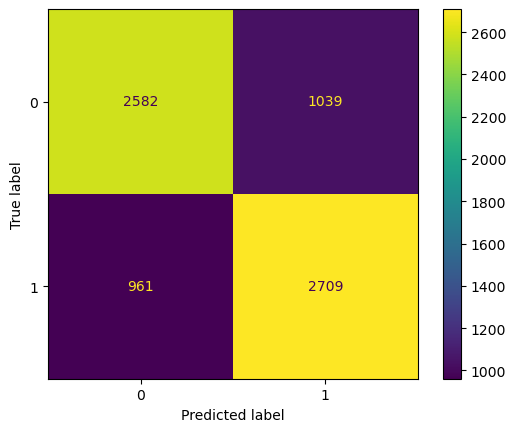

In [541]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

labels = [1,0]
cm = confusion_matrix(y_test, y_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [209]:
X_train.shape

(17011, 24)

In [210]:
X_test.shape

(7291, 24)

In [211]:
scaler = MinMaxScaler()
X_train_array = scaler.fit_transform(X_train)
X_train_array

array([[1.67786837e-01, 2.35066998e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.86346235e-02, 2.72996738e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.49506849e-04, 2.35067082e-03, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       ...,
       [1.90396942e-01, 2.35066998e-03, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.23150249e-01, 2.36536167e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.53808675e-01, 3.29197059e-03, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [212]:
X_train = pd.DataFrame(X_train_array, columns=X_train.columns, index=X_train.index)
X_train

,CurrentCompanyMarketCap,TotalOpportunityAmount,LegacySFInstance_RHP,LegacySFInstance_RxC,CurrentCompanyMarketCapCategory_Medium,CurrentCompanyMarketCapCategory_Mega,CurrentCompanyMarketCapCategory_Micro,CurrentCompanyMarketCapCategory_Not Available,CurrentCompanyMarketCapCategory_Private,CurrentCompanyMarketCapCategory_Small,...,CreateDateMonth_3,CreateDateMonth_4,CreateDateMonth_5,CreateDateMonth_6,CreateDateMonth_7,CreateDateMonth_8,CreateDateMonth_9,CreateDateMonth_10,CreateDateMonth_11,CreateDateMonth_12
17220,0.167787,0.002351,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7311,0.028635,0.002730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
22066,0.000450,0.002351,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11247,0.000083,0.002351,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8569,0.453809,0.002360,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,0.225201,0.002686,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19648,0.773877,0.002519,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9845,0.190397,0.002351,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10799,0.223150,0.002365,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [213]:
X_test_array = scaler.transform(X_test)
 
X_test_array
X_test = pd.DataFrame(X_test_array, columns=X_test.columns, index=X_test.index)
X_test.head()

,CurrentCompanyMarketCap,TotalOpportunityAmount,LegacySFInstance_RHP,LegacySFInstance_RxC,CurrentCompanyMarketCapCategory_Medium,CurrentCompanyMarketCapCategory_Mega,CurrentCompanyMarketCapCategory_Micro,CurrentCompanyMarketCapCategory_Not Available,CurrentCompanyMarketCapCategory_Private,CurrentCompanyMarketCapCategory_Small,...,CreateDateMonth_3,CreateDateMonth_4,CreateDateMonth_5,CreateDateMonth_6,CreateDateMonth_7,CreateDateMonth_8,CreateDateMonth_9,CreateDateMonth_10,CreateDateMonth_11,CreateDateMonth_12
1620,0.004373,0.004053,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
23914,0.018135,0.002356,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6721,1.000000,0.002440,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
20628,0.000006,0.002983,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7260,0.089539,0.002376,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [214]:
import statsmodels.api as sm #logistic regression with summary

In [215]:
newX = sm.add_constant(X_train)
newX.head()

,const,CurrentCompanyMarketCap,TotalOpportunityAmount,LegacySFInstance_RHP,LegacySFInstance_RxC,CurrentCompanyMarketCapCategory_Medium,CurrentCompanyMarketCapCategory_Mega,CurrentCompanyMarketCapCategory_Micro,CurrentCompanyMarketCapCategory_Not Available,CurrentCompanyMarketCapCategory_Private,...,CreateDateMonth_3,CreateDateMonth_4,CreateDateMonth_5,CreateDateMonth_6,CreateDateMonth_7,CreateDateMonth_8,CreateDateMonth_9,CreateDateMonth_10,CreateDateMonth_11,CreateDateMonth_12
17220,1.0,0.167787,0.002351,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7311,1.0,0.028635,0.002730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
22066,1.0,0.000450,0.002351,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11247,1.0,0.000083,0.002351,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8569,1.0,0.453809,0.002360,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [216]:
lm = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
lm.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              StageName   No. Observations:                17011
Model:                            GLM   Df Residuals:                    16986
Model Family:                Binomial   Df Model:                           24
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10899.
Date:                Thu, 14 Mar 2024   Deviance:                       21799.
Time:                        15:12:13   Pearson chi2:                 1.70e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.09953
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -0.4499      0.080     -5.647      0.000      -0.606      -0.294
CurrentCompanyMarketCap                           0.1632      0.137      1.194      0.232      -0.105       0.431
TotalOpportunityAmount                           -1.4299      1.322     -1.081      0.280      -4.022       1.162
LegacySFInstance_RHP                              0.2177      0.053      4.085      0.000       0.113       0.322
LegacySFInstance_RxC                              0.0487      0.050      0.977      0.328      -0.049       0.146
CurrentCompanyMarketCapCategory_Medium           -0.0394      0.064     -0.616      0.538      -0.165       0.086
CurrentCompanyMarketCapCategory_Mega             -0.1484      0.067     -2.209      0.027      -0.280      -0.017
CurrentCompanyMarketCapCategory_Micro            -0.4541      0.072     -6.347      0.000      -0.594      -0.314
CurrentCompanyMarketCapCategory_Not Available     0.1707      0.104      1.643      0.100      -0.033       0.374
CurrentCompanyMarketCapCategory_Private          -0.0156      0.055     -0.285      0.776      -0.123       0.091
CurrentCompanyMarketCapCategory_Small            -0.1367      0.073     -1.864      0.062      -0.281       0.007
Top24CMMCompany_YES                               0.0541      0.046      1.165      0.244      -0.037       0.145
OpportunityType_Renewal                           1.3807      0.043     32.353      0.000       1.297       1.464
OpportunityType_Termination                       1.3959      0.289      4.836      0.000       0.830       1.962
CreateDateMonth_2                                 0.2074      0.087      2.380      0.017       0.037       0.378
CreateDateMonth_3                                 0.1851      0.081      2.282      0.022       0.026       0.344
CreateDateMonth_4                                 0.0951      0.085      1.118      0.264      -0.072       0.262
CreateDateMonth_5                                -0.1080      0.087     -1.243      0.214      -0.278       0.062
CreateDateMonth_6                                -0.0492      0.082     -0.598      0.550      -0.210       0.112
CreateDateMonth_7                                -0.0601      0.084     -0.717      0.473      -0.224       0.104
CreateDateMonth_8                                 0.1375      0.081      1.703      0.089      -0.021       0.296
CreateDateMonth_9                                -0.2917      0.079     -3.697      0.000      -0.446      -0.137
CreateDateMonth_10                               -0.0193      0.081     -0.239      0.811      -0.178       0.140
CreateDateMonth_11                                0.1450      0.086      1.696      0.090      -0.023       0.313
Creat

In [217]:
from sklearn.linear_model import LogisticRegression # logistic regression with RFE
from sklearn.feature_selection import RFE #recursive feature elimination
from statsmodels.stats.outliers_influence import variance_inflation_factor #variable selection

In [218]:
# Use the sklearn logistic regression model for RFE and VIF features
 
##instantiate logistic regression model
lr = LogisticRegression()
rfe = RFE(estimator=lr, n_features_to_select=9)
rfe = rfe.fit(X_train, y_train)

In [219]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))
col = X_train.columns[rfe.support_]
col
X_train = sm.add_constant(X_train[col])
X_train

,const,TotalOpportunityAmount,LegacySFInstance_RHP,CurrentCompanyMarketCapCategory_Micro,CurrentCompanyMarketCapCategory_Not Available,OpportunityType_Renewal,OpportunityType_Termination,CreateDateMonth_2,CreateDateMonth_9,CreateDateMonth_12
17220,1.0,0.002351,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7311,1.0,0.002730,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
22066,1.0,0.002351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11247,1.0,0.002351,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8569,1.0,0.002360,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
13123,1.0,0.002686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19648,1.0,0.002519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9845,1.0,0.002351,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10799,1.0,0.002365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [222]:
lm = sm.GLM(y_train,X_train, family = sm.families.Binomial())
lm.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              StageName   No. Observations:                17011
Model:                            GLM   Df Residuals:                    17002
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10921.
Date:                Thu, 14 Mar 2024   Deviance:                       21842.
Time:                        15:12:26   Pearson chi2:                 1.70e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.09726
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -0.3774      0.023    -16.691      0.000      -0.422      -0.333
LegacySFInstance_RHP                              0.1774      0.039      4.587      0.000       0.102       0.253
CurrentCompanyMarketCapCategory_Micro            -0.4447      0.065     -6.800      0.000      -0.573      -0.317
CurrentCompanyMarketCapCategory_Not Available     0.2094      0.101      2.070      0.038       0.011       0.408
OpportunityType_Renewal                           1.3707      0.041     33.419      0.000       1.290       1.451
OpportunityType_Termination                       1.3877      0.288      4.815      0.000       0.823       1.953
CreateDateMonth_2                                 0.1665      0.064      2.613      0.009       0.042       0.291
CreateDateMonth_9                                -0.3348      0.052     -6.464      0.000      -0.436      -0.233
CreateDateMonth_12                                0.3040      0.072      4.198      0.000       0.162       0.446
=================================================================================================================
"""

In [221]:


X_train = X_train.drop(['TotalOpportunityAmount'], axis =1)

In [223]:
    #VIF
######check VIF for correlation
 
#create a dataframe containing VIFs
vif = pd.DataFrame()
vif['Features'] = X_train.columns
#shape[1] gets the number of columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
 
print(vif) # all under 10-15

                                        Features   VIF
0                                          const  2.06
1                           LegacySFInstance_RHP  1.20
4                        OpportunityType_Renewal  1.17
7                              CreateDateMonth_9  1.03
5                    OpportunityType_Termination  1.02
6                              CreateDateMonth_2  1.02
3  CurrentCompanyMarketCapCategory_Not Available  1.01
8                             CreateDateMonth_12  1.01
2          CurrentCompanyMarketCapCategory_Micro  1.00


In [224]:
y_train_predict = lm.fit().predict(X_train)
 
print(y_train_predict)

17220    0.329118
7311     0.658918
22066    0.406757
11247    0.344185
8569     0.763263
           ...   
13123    0.406757
19648    0.406757
9845     0.502360
10799    0.406757
2732     0.450166
Length: 17011, dtype: float64


In [225]:
y_train_predict2 = pd.DataFrame({'StageName':y_train.values, 'StageNameProbability':y_train_predict})
y_train_predict2.head()

,StageName,StageNameProbability
17220,0,0.329118
7311,1,0.658918
22066,0,0.406757
11247,1,0.344185
8569,1,0.763263


In [226]:
y_train_predict2['Prediction'] = y_train_predict2.StageNameProbability.map(lambda x: 1 if x > 0.5 else 0)
y_train_predict2

,StageName,StageNameProbability,Prediction
17220,0,0.329118,0
7311,1,0.658918,1
22066,0,0.406757,0
11247,1,0.344185,0
8569,1,0.763263,1
...,...,...,...
13123,0,0.406757,0
19648,0,0.406757,0
9845,1,0.502360,1
10799,1,0.406757,0


In [227]:
from sklearn import metrics #model performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score #model performance
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score #Receiver operating characteristic
### confusion matrix to understand how good the model is 
cmatrix = metrics.confusion_matrix(y_train_predict2.StageName, y_train_predict2.Prediction )
print(cmatrix)

[[7192 1338]
 [4933 3548]]


In [228]:
TN = cmatrix[0,0] # true negatives
print("True Negatives", TN)
FP = cmatrix[0,1] # false positives
print("False Positives", FP)
FN = cmatrix[1,0] # false negatives
print("False Negatives", FN)
TP = cmatrix[1,1] # true positive 
print("True Positives", TP)

True Negatives 7192
False Positives 1338
False Negatives 4933
True Positives 3548


In [229]:
accuracy = metrics.accuracy_score(y_train_predict2.StageName, y_train_predict2.Prediction)
#(TN+TP) / (TP+TN+FP+FN)
print("Accuracy", accuracy) #61.86%
 
sensitivity = TP / (TP+FN)
print("Sensitivity", sensitivity) #61.15%
 
specificity = TN/ (TN+FP)
print("Specificity", specificity) #62.76%
 
precision = TP / (TP+FP)
print("Precision", precision) #67.67%

Accuracy 0.6313561812944565
Sensitivity 0.4183468930550643
Specificity 0.8431418522860492
Precision 0.7261563651248465


In [177]:
X_train

,const,LegacySFInstance_RHP,CurrentCompanyMarketCapCategory_Micro,CurrentCompanyMarketCapCategory_Not Available,OpportunityType_Renewal,OpportunityType_Termination,CreateDateMonth_2,CreateDateMonth_9,CreateDateMonth_12
17220,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7311,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
22066,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11247,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8569,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
13123,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19648,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9845,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10799,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [230]:
cols_to_keep = ['LegacySFInstance_RHP', 'CurrentCompanyMarketCapCategory_Micro', 'CurrentCompanyMarketCapCategory_Not Available', 'OpportunityType_Renewal', 'OpportunityType_Termination', 'CreateDateMonth_2', 'CreateDateMonth_9', 'CreateDateMonth_12']

X_test = X_test[cols_to_keep]
X_test = sm.add_constant(X_test)

y_test_predic = lm.fit().predict(X_test)
y_test_predic

y_test_predic2 = pd.DataFrame({'StageName':y_test.values, 'StageNameProbability':y_test_predic})
y_test_predic2.head()

y_test_predic2['Prediction'] = y_test_predic2.StageNameProbability.map(lambda x: 1 if x > 0.5 else 0)
y_test_predic2.head()

,StageName,StageNameProbability,Prediction
1620,1,0.697594,1
23914,0,0.763263,1
6721,1,0.450166,0
20628,0,0.709395,1
7260,1,0.406757,0


In [231]:
cmatrix2 = metrics.confusion_matrix(y_test_predic2.StageName, y_test_predic2.Prediction )
print(cmatrix2)

[[3062  559]
 [2092 1578]]


In [232]:
TN2 = cmatrix2[0,0] # true negatives
print("True Negatives", TN2)
FP2 = cmatrix2[0,1] # false positives
print("False Positives", FP2)
FN2 = cmatrix2[1,0] # false negatives
print("False Negatives", FN2)
TP2 = cmatrix2[1,1] # true positive 
print("True Positives", TP2)

True Negatives 3062
False Positives 559
False Negatives 2092
True Positives 1578


In [233]:
accuracy = metrics.accuracy_score(y_test_predic2.StageName, y_test_predic2.Prediction)
#(TN+TP) / (TP+TN+FP+FN)
print("Accuracy", accuracy) #61.86% train -> 61.14% test
 
sensitivity = TP2 / (TP2+FN2)
print("Sensitivity", sensitivity) #61.15% train -> 59.63% test
 
specificity = TN2/ (TN2+FP2)
print("Specificity", specificity) #62.76% train -> 63.04% test
 
precision = TP2 / (TP2+FP2)
print("Precision", precision) #67.67% -> 67.97% test

Accuracy 0.6364010423810177
Sensitivity 0.42997275204359675
Specificity 0.8456227561447114
Precision 0.7384183434721572


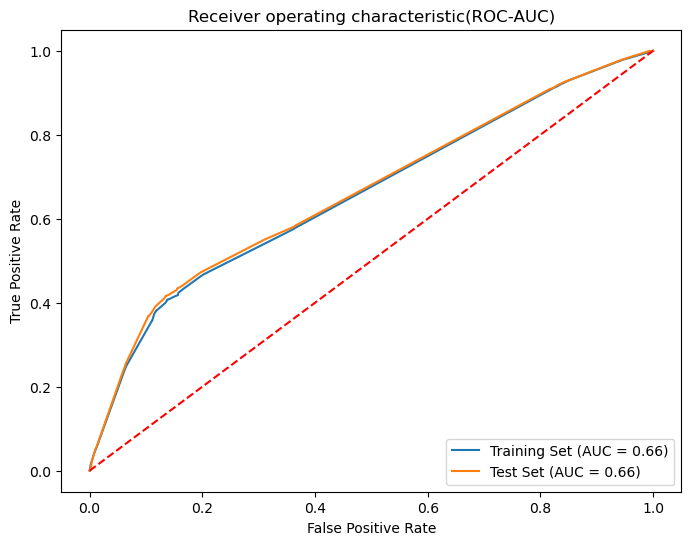

In [234]:
fpr, tpr, thresholds = roc_curve(y_train, y_train_predict)
roc_auc = roc_auc_score(y_train, y_train_predict)

fpr2, tpr2, thresholds2 = roc_curve(y_test, y_test_predic)
roc_auc2 = roc_auc_score(y_test, y_test_predic)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='Training Set (AUC = %0.2f)' % roc_auc)
plt.plot(fpr2, tpr2,label='Test Set (AUC = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic(ROC-AUC)')
plt.legend(loc="lower right")
plt.show()